# Sidewalk AI Pipeline

From a screenshot of the app (image with a grid) to sidewalk width estimation.
Other things in the folder:
- **input_frames** and **input_videos** - Input data (app screenshots and videos)
- **useful_figures** - Figures from the pipeline, useful for the report
- **export** - Exported data and images from the pipeline
- **gen_sequence_from_video.py** - Script to generate a sequence of images from a video, --help for usage
- **segment_image.py** - Script to segment an image, --help for usage. You'll need to move this to a different folder, see setup for details.

The best results from the pipeline are in the export folder for simple0/big1, path0/frame3, path1/frame1, single/big3, and single/frame1. Some interesting ones, mainly demo-ing the **limitations of the segmentation model**, are simple0/big2, path0/frame1, path2/2, and path3/red4.

Feel free to ask/email me (kylefu@mit.edu) if you have any questions about the pipeline, I'd be happy to help :)

## Setup

Install the required modules with this pip command. Consider using a virtual environment.

`pip install opencv-python numpy matplotlib networkx scikit-learn`

In addition, this notebook requires a pretrained segmentation model from [this Github repository](https://github.com/JunHyeok96/Road-Segmentation).

1. Clone the repo into the same directory as this notebook.
2. Place the provided `segment_image.py` script into the `Road-Segmentation` directory.
3. Inside the `Road-Segmentation` directory, create a virtual environment for **Python 3.6.x**. The version number must match. **Make sure it's in the venv folder!**
- You can install Python 3.6 [here](https://www.python.org/downloads/release/python-368/). Reference this Python interpreter when making the virtual environment, something like `python3.6 -m venv ./venv`.
4. Install the required modules and versions for the segmentation model's virtual environment: `pip install --upgrade pip; pip install opencv-python tensorflow-gpu==2.0.0 h5py==2.10.0 ipython matplotlib`

With debug mode enabled, all images will be saved to the `temp` directory, in addition to the export data. This can be used to further visualize and generate figures from the pipeline.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import subprocess
import os
import json
from collections import deque, defaultdict
from sklearn.cluster import DBSCAN
from typing import List, Optional

if not os.path.exists("Road-Segmentation"):
    print("ERROR: The Road-Segmentation directory does not exist. Please clone the repository.")
elif not os.path.exists("Road-Segmentation/segment_image.py"):
    print("ERROR: The segment_image.py script is not in the Road-Segmentation directory.")
elif not os.path.exists("Road-Segmentation/venv"):
    print("ERROR: The segmentation model's virtual environment does not exist. Please create it.")

## Input
- App provides grid image frames (~1 per second), which may have a "Sidewalk AI" black header above them, through screenshots/screen recording.
- It might also provide raw image frames, maybe misaligned with the grid frames or at different resolutions. We realign the raw images later.

In [ ]:
# Path to grid image frame
INPUT_PATH_GRID = "input/img2.jpeg"
# Path to raw image frame, or None if there is no raw image
INPUT_PATH_RAW = "input/img1.jpeg"  # "input_frames/simple0/big1.png"
# Path to ground truth image (only for visualization), or None if there is no ground truth
INPUT_PATH_TRUTH = None
# Export path
EXPORT_PATH = "export"

# Vertical spacing between sidewalk width lines
LINE_SPACING = 40
# Number of grid line extrapolations on each side
NUM_EXTRAPOLATIONS = 0
# Visualization mode
DEBUG = True

# Grid color
GRID_COLOR = "red"
# Length of each grid square, in meters
METRIC_GRID_LENGTH = 0.5
# Length of each grid square, in pixels on the flattened image
PIXEL_GRID_LENGTH = 128

In [3]:
def show_images(images: List, titles: List[str], export = False) -> None:
    """Show BGR or grayscale images in a row.
    
    Args:
        images (List): List of images to show.
        titles (List[str]): List of titles for each image.
        export (bool): Whether to save the images to the export directory.
    """
    fig, axes = plt.subplots(1, len(images), figsize=(20, 10), squeeze=False)
    for i, (image, title) in enumerate(zip(images, titles)):
        if len(image.shape) == 3:
            axes[0][i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        else:
            axes[0][i].imshow(image, cmap='gray')
        # Save to disk
        cv2.imwrite(f'temp/{title}.png', image)
        # Save to export directory
        if export:
            cv2.imwrite(f'{EXPORT_PATH}/{title}.png', image)
        axes[0][i].set_title(title)
        axes[0][i].axis('off')
    plt.show()


In [4]:
def show_image(image: np.ndarray, title: str = "Result", export = False) -> None:
    """Show BGR or grayscale image.
    
    Args:
        image (np.ndarray): Image to show.
        title (str): Title for the image.
        export (bool): Whether to save the image to the export directory.
    """
    show_images([image], [title], export)

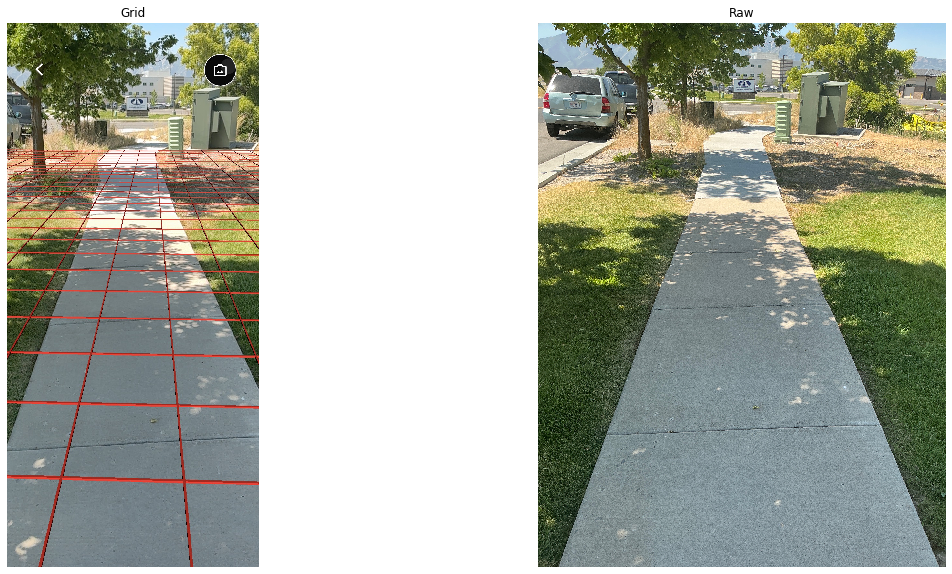

In [5]:
# Make export directory
os.makedirs(EXPORT_PATH, exist_ok=True)
# Load and show all images
grid_image = cv2.imread(INPUT_PATH_GRID)
raw_image = cv2.imread(INPUT_PATH_RAW) if INPUT_PATH_RAW else None
truth_image = cv2.imread(INPUT_PATH_TRUTH) if INPUT_PATH_TRUTH else None
# Show the images
if DEBUG:
    shown_images, shown_titles = [grid_image], ["Grid"]
    if raw_image is not None:
        shown_images.append(raw_image)
        shown_titles.append("Raw")
    if truth_image is not None:
        shown_images.append(truth_image)
        shown_titles.append("Ground truth")
    show_images(shown_images, shown_titles)

## Data preparation
**Get a pair of same resolution images, one with the grid, one without.**

One way, if we don't have a raw image, is to generate the raw images from the grid images. This is done via inpainting - filling in the grid portion by copying the surrounding pixels. Note that this normally leads to pretty bad segmentation results, unless the grid image has a high resolution.

If we have a raw image, we can realign it with the grid image. This is done by finding the transformation matrix that maps the grid image to the raw image, with an ORB feature matcher.

- Note: If this steps takes a long time, **consider downscaling the input images first.**
- Note 2: If the raw image looks nothing like the grid image, **consider setting raw image to None to use inpainting.**

In [6]:
def get_grid_mask(image: np.ndarray, color: str, dilate = 0) -> np.ndarray:
    """
    Args:
        image: The input image.
        color: The color of the grid lines, either "red" or "blue".
        dilate: The amount of dilation to apply to the mask.
    
    Returns:
        A binary mask of the grid lines, where the grid lines are white (255).
    """
    # Convert the image to the HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    # Define the lower and upper bounds and make mask for the color
    if color == "red":
        # Two valid ranges for red
        lower1 = np.array([0, 70, 50])
        upper1 = np.array([10, 255, 255])
        lower2 = np.array([170, 70, 50])
        upper2 = np.array([180, 255, 255])
        mask1 = cv2.inRange(hsv, lower1, upper1)
        mask2 = cv2.inRange(hsv, lower2, upper2)
        mask = cv2.bitwise_or(mask1, mask2)
    elif color == "blue":
        lower = np.array([80, 50, 50])
        upper = np.array([140, 255, 255])
        mask = cv2.inRange(hsv, lower, upper)
    else:
        raise ValueError("color must be either 'red' or 'blue'")
    # Apply some dilation to the mask
    if dilate > 0:
        kernel = np.ones((dilate, dilate), np.uint8)
        mask = cv2.dilate(mask, kernel, iterations=1)
    return mask

In [7]:
def align_images(image1, image2):
    """Align image2 to image1 using feature matching and homography."""
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Detect ORB features and compute descriptors
    orb = cv2.ORB_create()
    keypoints1, descriptors1 = orb.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = orb.detectAndCompute(gray2, None)

    # Match features using KNN
    matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    matches = matcher.match(descriptors1, descriptors2)

    # Sort matches by distance
    matches = sorted(matches, key=lambda x: x.distance)

    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)

    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt

    # Find homography
    H, mask = cv2.findHomography(points2, points1, cv2.RANSAC)

    # Use homography to warp image2 to match image1
    height, width, channels = image1.shape
    aligned_image2 = cv2.warpPerspective(image2, H, (width, height))

    return aligned_image2

In [8]:
def remove_grid_from_image(image: np.ndarray, color: str, inpaint_radius = 5) -> np.ndarray:
    """
    Args:
        image: The input image.
        color: The color of the grid lines, either "red" or "blue".
        inpaint_radius: The radius around the grid lines to inpaint. Must be odd.
    
    Returns:
        The image with the grid lines removed.
    """
    # Get and dilate the grid mask
    mask = get_grid_mask(image, color, dilate=max(1, inpaint_radius - 2))
    # Inpaint the grid using the mask
    result = cv2.inpaint(image, mask, inpaint_radius, cv2.INPAINT_TELEA)
    return result


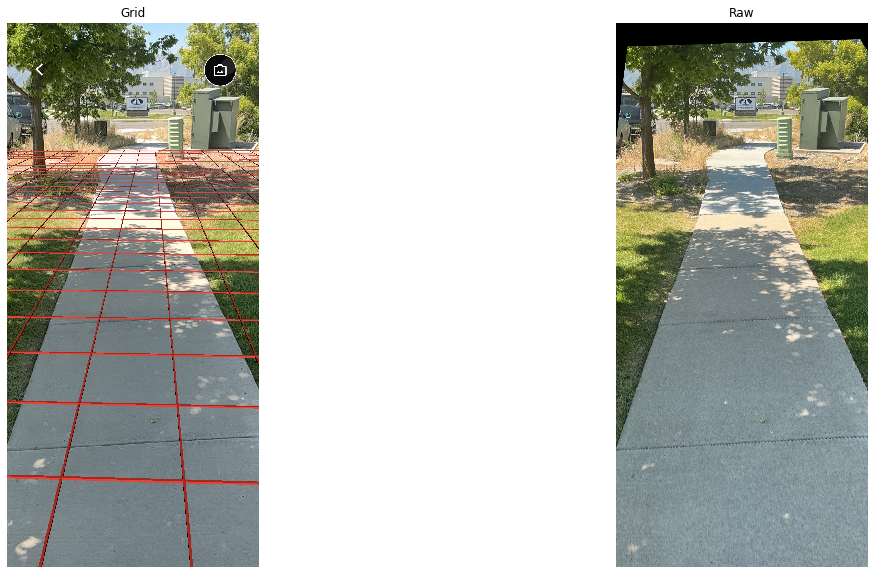

In [11]:
# Generate or align the raw image
if raw_image is None:
    # Generate the raw image from the grid image
    raw_image = remove_grid_from_image(grid_image, GRID_COLOR)
else:
    # Align the raw image to the grid image
    raw_image = align_images(grid_image, raw_image)
# Show the images
if DEBUG:
    show_images([grid_image, raw_image], ["Grid", "Raw"])

## Sidewalk segmentation

**Find the sidewalk in the image.**

We use a pretrained version of PSPUNet, available at [this Github repository](https://github.com/JunHyeok96/Road-Segmentation), to segment the sidewalk.

The below code segment uses an external Python script `segment_image.py` to perform the segmentation.

In [12]:
def segment_image(image: np.ndarray, debug: bool = False):
    """Runs the image segmentation pipeline on image.

    Args:
        image: The input image.
        debug: Whether to show intermediate results.
    
    Returns:
        The road segmentation mask as a binary image.
    """
    # Make temporary directory
    temp_dir = "temp"
    os.makedirs(temp_dir, exist_ok=True)

    venv_python_path = "venv/bin/python3"
    script_to_run = "segment_image.py"
    directory_to_cd = "Road-Segmentation"
    input_path = os.path.abspath(f"{temp_dir}/input.png")
    output_path = os.path.abspath(f"{temp_dir}/segment")

    # Run image segmentation script within a virtual environment
    cv2.imwrite(input_path, image)
    run_cmd = [venv_python_path, script_to_run, '--input', input_path, '--output', output_path]
    # Clear environment variables
    if debug:
        process = subprocess.Popen(run_cmd, env={}, cwd=directory_to_cd)
    else:
        process = subprocess.Popen(run_cmd, env={}, cwd=directory_to_cd, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    process.wait()  # Wait for the process to finish

    # Load the output image and csv
    output_image = cv2.imread(f"{output_path}.png")
    segment = np.loadtxt(f"{output_path}.csv", delimiter=",", dtype=int)

    # Label of 6 is the sidewalk
    segment = np.where(segment == 6, 255, 0).astype(np.uint8)
    # Closing operation to fill in small gaps
    kernel = np.ones((5, 5), np.uint8)
    segment = cv2.morphologyEx(segment, cv2.MORPH_CLOSE, kernel)
    # Only save the part with the largest contour area (the sidewalk)
    contours, _ = cv2.findContours(segment, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    largest_contour = max(contours, key=cv2.contourArea)
    segment = np.zeros_like(segment)
    cv2.drawContours(segment, [largest_contour], -1, (255, 255, 255), thickness=cv2.FILLED)
    
    if debug:
        show_images([output_image, segment], ["Segmentation", "Sidewalk mask"], export=True)

    return segment

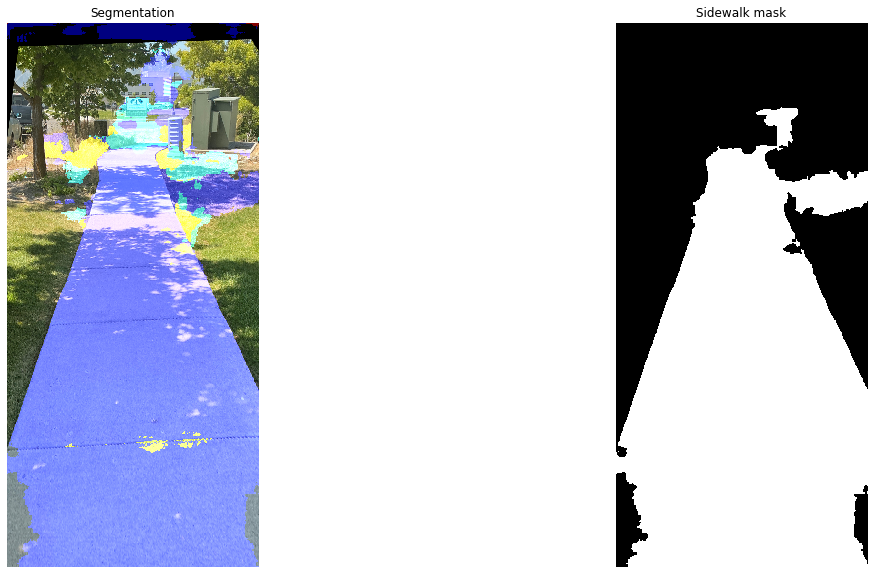

In [13]:
# Segment the raw image
segment_mask = segment_image(raw_image, debug=DEBUG)

## Grid detection

**Detect the grid in the image.**

Current method:
1. Find grid squares by looking for square-shaped boundaries in the grid. Get the 4 corner points for each grid square.
2. Apply DBSCAN to corner points in order to merge duplicate points.
3. Find adjacent grid squares by looking for which corner points were merged, and which were part of the same grid square.
4. Use the found grid squares to generate line equations for the grid lines.

In [14]:
def draw_text(canvas, text, x, y, w, font_color, scale=1):
    """Draw text on an image.

    Args:
        canvas: The image to draw the text on.
        text: The text to draw.
        x: The x-coordinate of the top-left corner of the text.
        y: The y-coordinate of the top-left corner of the text.
        w: The width of the text box.
        font_color: The color of the text.
        scale: The scale of the text.
    """
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = scale
    thickness = round(scale*3)
    text_size = cv2.getTextSize(text, font, font_scale, thickness)[0]
    text_x = x + (w - text_size[0]) // 2
    text_y = y
    cv2.putText(canvas, text, (text_x, text_y), font, font_scale, font_color, thickness, cv2.LINE_AA)

In [15]:
def find_grid_squares(image: np.ndarray, color: str, min_square_area = 0.00016, max_square_area = 0.01, debug = False) -> List[np.ndarray]:
    """
    Args:
        image: The input image.
        color: The color of the grid lines.
        min_square_area: The minimum area of a square, as a percentage of the image area.
        max_square_area: The maximum area of a square, as a percentage of the image area.
        debug: Whether to visualize results.
    
    Returns:
        A list of square contours.
    """
    def get_area_percent(image, contour):
        """Outputs the contour's area, as a percentage of the image area."""
        return cv2.contourArea(contour) / (image.shape[0] * image.shape[1])

    # Get the grid mask
    mask = get_grid_mask(image, color)
    # Invert the mask
    inverted_mask = cv2.bitwise_not(mask)
    # Find contours
    contours, _ = cv2.findContours(inverted_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Filter too small/large contours out
    contours = [cnt for cnt in contours if min_square_area <= get_area_percent(image, cnt) <= max_square_area]

    # Find grid squares and corner points
    squares = []
    for i, cnt in enumerate(contours):
        # Bounding box doesn't work, try to find a 4 point hull
        hull = cv2.convexHull(cnt)
        epsilon = 0.03 * cv2.arcLength(hull, True)
        approx_hull = cv2.approxPolyDP(hull, epsilon, True)
        if len(approx_hull) != 4: continue
        squares.append(approx_hull)
    
    # Visualize
    if debug:
        np.random.seed(321)
        output = image.copy()
        for i, cnt in enumerate(squares):
            M = cv2.moments(cnt)
            if M["m00"] != 0:
                cX = int(M["m10"] / M["m00"])
                cY = int(M["m01"] / M["m00"])
            else:
                # Can't divide by zero, set some default value or handle this case
                cX, cY = 0, 0
            color = np.random.randint(1, high=255, size=(3,)).tolist()
            cv2.drawContours(output, [cnt], 0, color, cv2.FILLED)
            # draw_text(output, f"{get_area_percent(image, cnt) * 100:.2f}%", cX, cY, 40, (0, 255, 0))
        show_image(output, "Squares")
    
    return squares

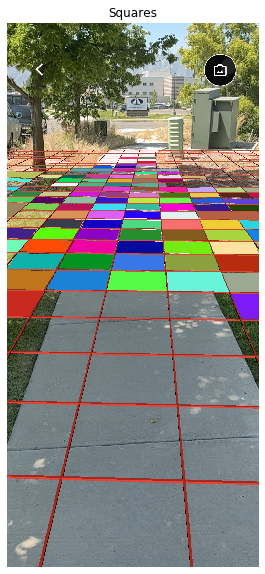

In [16]:
squares = find_grid_squares(grid_image, GRID_COLOR, debug=DEBUG)

In [29]:
def find_corner_points(image: np.ndarray, squares: List[np.ndarray], near_threshold = -1, debug = False):
    """
    Args:
        image: The input image.
        squares: A list of square contours.
        near_threshold: The maximum pixel distance between two points to be considered as the same. If -1, chosen automatically.
        debug: Whether to visualize results.
    
    Returns:
        A list of corner points, along with an adjacency list for adjacent points.
    """
    # If near_threshold is not given, choose automatically
    if near_threshold == -1:
        near_threshold = image.shape[0] * image.shape[1] / 150000

    # Convert points to a numpy array for DBSCAN
    candidate_points = [tuple(point[0]) for cnt in squares for point in cnt]
    points_array = np.array(candidate_points)
    clustering = DBSCAN(eps=near_threshold, min_samples=1).fit(points_array)

    # Compute centroids of clusters
    merged_points = [tuple(points_array[clustering.labels_ == i].mean(axis=0)) for i in range(clustering.labels_.max() + 1)]

    # Find grid points: O(N^2) for now
    def is_near_square(point, square):
        return any(np.linalg.norm(np.array(point) - np.array(corner)) < near_threshold for corner in square)

    filtered_points = [point for point in merged_points
                       if sum(is_near_square(point, square) for square in squares) == 4]
    
    # Find adjacent points: O(N^2)
    adj_squares = []
    grid_points = filtered_points
    # Find which squares are close to each point
    for point in grid_points:
        corners = set()
        for j, square in enumerate(squares):
            if is_near_square(point, square):
                corners.add(j)
        adj_squares.append(corners)

    class Edge:
        def __init__(self, n, d):
            self.n = n
            self.d = d
    
    # Find adjacent points, along with the direction between them ((0, 1) for horizontal, (1, 0) for vertical)
    adj_points = [[] for _ in range(len(grid_points))]
    for i in range(len(grid_points)):
        for j in range(len(grid_points)):
            if i == j: continue
            if len(adj_squares[i].intersection(adj_squares[j])) == 2:
                # Approximation for now
                is_hor = abs(grid_points[j][0] - grid_points[i][0]) > abs(grid_points[j][1] - grid_points[i][1])*4
                if is_hor:
                    d = (0, 1) if grid_points[j][0] > grid_points[i][0] else (0, -1)
                else:
                    d = (1, 0) if grid_points[j][1] > grid_points[i][1] else (-1, 0)
                adj_points[i].append(Edge(j, d))
    
    # Visualize
    if debug:
        print(f"Near threshold: {near_threshold}")
        print(f"Before merging: {len(candidate_points)} points")
        print(f"After merging: {len(merged_points)} points")
        print(f"Adjacent to four squares: {len(filtered_points)} points")
        output = image.copy()

        # Show adjacent points
        for i, point in enumerate(grid_points):
#             cv2.circle(output, [round(x) for x in point], radius=10, color=(0, 255, 0), thickness=cv2.FILLED)
            cv2.circle(output, tuple(int(round(x)) for x in point), radius=10, color=(0, 255, 0), thickness=cv2.FILLED)

            for e in adj_points[i]:
                j, is_hor = e.n, e.d[0] == 0
                color = (0, 255, 255) if is_hor else (255, 0, 255)
#                 cv2.line(output, [round(x) for x in point], [round(x) for x in grid_points[j]], color=color, thickness=5)
                cv2.line(output, tuple(int(round(x)) for x in point), tuple(int(round(x)) for x in grid_points[j]), color=color, thickness=5)
        
        # Show all found points
        for point in merged_points:
            color = (0, 255, 0) if point in filtered_points else (0, 0, 0)
            cv2.circle(output, tuple(int(round(x)) for x in point), radius=10, color=(0, 255, 0), thickness=cv2.FILLED)
#             cv2.circle(output, [round(x) for x in point], radius=10, color=color, thickness=cv2.FILLED)
        
        show_image(output, "Corner points")
    
    return grid_points, adj_points

Near threshold: 8.7776
Before merging: 404 points
After merging: 120 points
Adjacent to four squares: 46 points


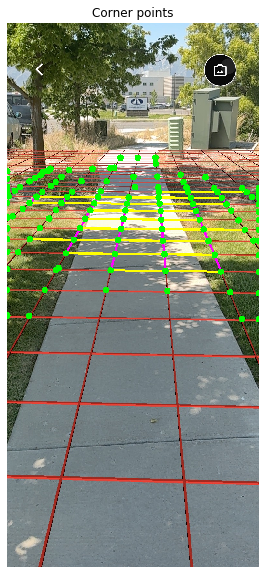

In [30]:
corner_points = find_corner_points(grid_image, squares, debug=DEBUG)

In [35]:
def organize_points(image: np.ndarray, grid_points: List, adj_points: List, debug: bool = False):
    """
    Args:
        image: The input image.
        grid_points: A list of corner points.
        adj_points: An adjacency list for adjacent points.
        debug: Whether to visualize results.
    
    Returns:
        A list of dictionaries for points on each horizontal and vertical line.
    """
    # Find largest connected component
    G = nx.DiGraph()
    for i, point in enumerate(grid_points):
        G.add_node(i, point=point)
    for i, point in enumerate(grid_points):
        for e in adj_points[i]:
            G.add_edge(i, e.n, d=e.d)

    # Find all connected components, sorted by size
    components = sorted(nx.weakly_connected_components(G), key=len, reverse=True)
    # Get the largest connected component
    largest_component = components[0]
    # Create a subgraph with only the largest component
    H = G.subgraph(largest_component).copy()

    # Get horizontal and vertical lines
    # TODO: What if we skip a line due to bad detections?

    # Initialize labels with None
    for node in H.nodes():
        H.nodes[node]['loc'] = None

    # Start BFS from an arbitrary node (e.g., the first node)
    start_node = list(H.nodes)[0]
    H.nodes[start_node]['loc'] = (0, 0)

    # Queue for BFS, initialized with the start node
    queue = deque([start_node])

    points_hor = defaultdict(list)
    points_vert = defaultdict(list)

    while queue:
        current_node = queue.popleft()
        row, col = H.nodes[current_node]['loc']

        # Add node to lines
        points_hor[row].append(H.nodes[current_node]['point'])
        points_vert[col].append(H.nodes[current_node]['point'])

        # Check all neighbors
        for neighbor in H.neighbors(current_node):
            edge_data = H.get_edge_data(current_node, neighbor)
            if H.nodes[neighbor]['loc'] is None:
                # Update neighbor's label
                d_row, d_col = edge_data['d']
                new_label = (row + d_row, col + d_col)
                H.nodes[neighbor]['loc'] = new_label
                queue.append(neighbor)

    # Visualize
    if debug:
        print("Largest connected component:", H)
        output = image.copy()
        np.random.seed(321)
        for i, (row, points) in enumerate(points_hor.items()):
            color = np.random.randint(0, high=255, size=(3,)).tolist()
            for point in points:
#                 cv2.circle(output, [round(x) for x in point], radius=10, color=color, thickness=cv2.FILLED)
                cv2.circle(output, tuple(int(round(x)) for x in point), radius=10, color=color, thickness=cv2.FILLED)
        for n in H.nodes:
            draw_text(output, f"{(H.nodes[n]['loc'][0],H.nodes[n]['loc'][1])}", int(round(grid_points[n][0])), int(round(grid_points[n][1])) - 20, 50, (0, 255, 0), scale=0.8)
        show_image(output, "Organized grid points")
    
    return points_hor, points_vert

Largest connected component: 


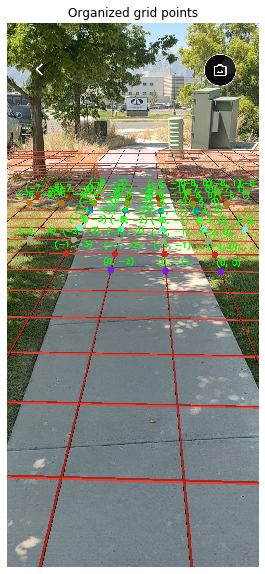

In [36]:
points_hor, points_vert = organize_points(grid_image, corner_points[0], corner_points[1], debug=DEBUG)

In [37]:
def get_best_fit_line(points):
    """Finds the best fit line for a set of points.
    
    Args:
        points: A list of (x, y) points.

    Returns:
        A tuple (slope, intercept) for the best fit line.
    """
    # TODO: REMOVE OUTLIERS TO MAKE THIS MORE CONSISTENT
    # Perform linear regression to find the best fit line
    # print(points)
    x = [point[0] for point in points]
    y = [point[1] for point in points]
    # Will just issue RankWarning if it's a vertical line
    coefficients = np.polyfit(x, y, 1)
    # The coefficients are in the form [slope, intercept]
    slope, intercept = coefficients
    return slope, intercept

In [38]:
def get_grid_from_points(image: np.ndarray, points_hor: dict, points_vert: dict, debug: bool = False):
    """
    Args:
        image: The input image.
        points_hor: A dictionary of points on each horizontal line.
        points_vert: A dictionary of points on each vertical line.
        debug: Whether to visualize results.
    
    Returns:
        The best fit lines for each row and column.
    """
    # Find best fit lines for each by iteratively applying best fit algorithm
    lines_hor = defaultdict(list)
    lines_vert = defaultdict(list)
    updated = True
    while updated:
        updated = False
        for row, points in points_hor.items():
            if len(points) < 2: continue  # Cannot fit a line
            lines_hor[row] = get_best_fit_line(points)
        for col, points in points_vert.items():
            if len(points) < 2: continue  # Cannot fit a line
            lines_vert[col] = get_best_fit_line(points)

    # Visualize
    if debug:
        # Get the dimensions of the image
        height, width = image.shape[:2]
        # print(lines_hor)
        # print(lines_vert)

        output = image.copy()
        np.random.seed(1337)
        for row, (slope, intercept) in lines_hor.items():
            # Calculate the y-coordinates for the left and right edges
            y1 = int(slope * 0 + intercept)  # x = 0 for the left edge
            y2 = int(slope * width + intercept)  # x = width for the right edge
            
            # Draw the line
            cv2.line(output, (0, y1), (width, y2), (0, 255, 0), 5)  # Change color and thickness as needed
        for vert, (slope, intercept) in lines_vert.items():
            # Calculate the y-coordinates for the left and right edges
            y1 = int(slope * 0 + intercept)  # x = 0 for the left edge
            y2 = int(slope * width + intercept)  # x = width for the right edge
            
            # Draw the line
            cv2.line(output, (0, y1), (width, y2), (0, 255, 0), 5)  # Change color and thickness as needed
        show_image(output, "Grid lines", export=True)
    
    return lines_hor, lines_vert

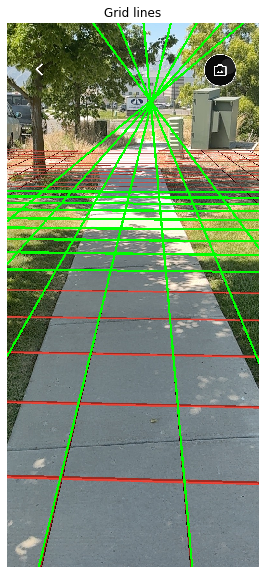

In [39]:
lines_hor, lines_vert = get_grid_from_points(grid_image, points_hor, points_vert, debug=DEBUG)
sorted_hor = sorted(lines_hor.items())[::-1]
sorted_vert = sorted(lines_vert.items())

## Grid extrapolation (optional)

**Generate more lines to improve distance estimation.**

Sometimes, the grid detection algorithm above doesn't find enough grid lines that are far away or on the sides. However, the lines are spaced apart in a pattern (especially the vertical ones), so we can extrapolate to fill in the rest of the grid.

The extrapolation for vertical lines is very good, but horizontal lines don't work as well. So, only the code for vertical line extrapolation is included. Also, this code is a bit redundant because the perspective transform can generalize beyond the grid boundaries.

In [40]:
def find_intersection(l1: tuple, l2: tuple) -> Optional[tuple]:
    """Finds the intersection of two lines.

    Args:
        l1: A tuple (m, b) for the first line y = mx + b.
        l2: A tuple (m, b) for the second line y = mx + b.
    
    Returns:
        The (x, y) coordinates of the intersection, or None if the lines are parallel.
    """
    m1, b1 = l1
    m2, b2 = l2
    # Check if the lines are parallel
    if m1 == m2:
        return None  # No intersection (lines are parallel)
    # Solve for x
    x = (b2 - b1) / (m1 - m2)
    # Solve for y
    y = m1 * x + b1
    return (x, y)

In [41]:
def get_dist(p1: tuple, p2: tuple) -> float:
    """Finds the distance between two points."""
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

In [42]:
def extrapolate_vert_point(hor_line, sorted_vert, in_dir="r") -> List[int]:
    """ Extrapolates the next point to the right or left of the existing lines.

    Args:
        hor_line: The horizontal line to find the intersection with.
        sorted_vert: A sorted list of lines, in the form [slope, intercept].
        in_dir: The direction to extrapolate in, either "r" or "l".
    
    Returns:
        The point that the next vertical line to the right/left of existing lines should go through.
    """
    def find_point_on_line(line, p0, dist):
        # print(line, p0, dist)
        m, b = line
        p0 = np.array(p0)
        # Direction vector for the line (dx, dy). We choose dx = 1 for simplicity, dy = m
        direction = np.array([1, m])
        # Normalize the direction vector
        unit_vector = direction / np.linalg.norm(direction)
        # Calculate the new point C
        C = p0 + dist * unit_vector
        return C
    
    # Find points on each horizontal line
    between = []
    for col, vert_line in sorted_vert:
        between.append(find_intersection(hor_line, vert_line))
    # Extrapolate the next point on each horizontal line
    dists = [get_dist(between[i], between[i+1]) for i in range(len(between)-1)]
    col_num = [i for i in range(len(dists))]
    coefficients = np.polyfit(col_num, dists, deg=1)
    fitted_func = np.poly1d(coefficients)
    # In the given direction
    if in_dir == "r":
        next_dist = fitted_func(len(dists))
        next_point = find_point_on_line(hor_line, find_intersection(hor_line, sorted_vert[-1][1]), next_dist)
        return next_point
    elif in_dir == "l":
        next_dist = fitted_func(-1)
        next_point = find_point_on_line(hor_line, find_intersection(hor_line, sorted_vert[0][1]), -next_dist)
        return next_point
    else:
        raise ValueError("in_dir must be either 'r' or 'l'")

In [43]:
def draw_slope_intercept_line(canvas: np.ndarray, line: List[int], color = (0, 255, 0), thickness = 5) -> None:
    """Draw a line in [slope, intercept] form on an image.
    
    Args:
        canvas: The image to draw the line on.
        line: The line to draw, in the form [slope, intercept].
        color: The color of the line.
        thickness: The thickness of the line.
    """
    slope, intercept = line
    # Get the dimensions of the image
    height, width = canvas.shape[:2]
    # Calculate the y-coordinates for the left and right edges
    y1 = int(slope * 0 + intercept)  # x = 0 for the left edge
    y2 = int(slope * width + intercept)  # x = width for the right edge
    # Draw the line
    cv2.line(canvas, (0, y1), (width, y2), color, thickness)  # Change color and thickness as needed

In [44]:
def extrapolate_line(image: np.ndarray, sorted_hor, sorted_vert, in_dir: str, debug = False):
    """ Extrapolates the next line in the given direction. Mutates sorted_vert.

    Args:
        sorted_hor: A sorted list of lines, in the form [slope, intercept].
        sorted_vert: A sorted list of lines, in the form [slope, intercept].
        in_dir: The direction to extrapolate in, either "l" or "r".
        debug: Whether to visualize results.
    """
    points = []
    if in_dir in "lr":
        # Find points for this line
        for row, hor_line in sorted_hor:
            point = extrapolate_vert_point(hor_line, sorted_vert, in_dir=in_dir)
            points.append(point)
        # Get best fit line
        curr_line = get_best_fit_line(points)
        # Add to sorted_vert
        if in_dir == "r":
            sorted_vert.append((sorted_vert[-1][0]+1, curr_line))
        else:
            sorted_vert.insert(0, (sorted_vert[0][0]-1, curr_line))
    else:
        print("Invalid dir", in_dir)
        return None

    # Visualize
    if debug:
        print("Extrapolated line with slope", curr_line[0], "and intercept", curr_line[1])
        # output = image.copy()
        # for i, point in enumerate(points):
        #     cv2.circle(output, [round(x) for x in point], radius=20//2, color=(0, 255, 255), thickness=cv2.FILLED)
        # draw_slope_intercept_line(output, curr_line, color=(0, 255, 255), thickness=5)
        # show_image(output, "Extrapolated line")

In [45]:
sorted_hor = sorted(lines_hor.items())[::-1]
sorted_vert = sorted(lines_vert.items())
for _ in range(NUM_EXTRAPOLATIONS):
    extrapolate_line(grid_image, sorted_hor, sorted_vert, in_dir="r", debug=True)
for _ in range(NUM_EXTRAPOLATIONS):
    extrapolate_line(grid_image, sorted_hor, sorted_vert, in_dir="l", debug=True)

## Top-down transformation

**Transform the image to a top-down view.**

The grid lines can be used to transform the image to a top-down view, using a perspective transform (homography). This is because we can choose a rectangle in the grid with a known metric width and height, then map it to a rectangle in the top-down view.

In [46]:
def draw_grid(canvas: np.ndarray, sorted_hor, sorted_vert):
    """Draws the grid on an image.

    Args:
        canvas: The image to draw the grid on.
        sorted_hor: A sorted list of lines, in the form [slope, intercept].
        sorted_vert: A sorted list of lines, in the form [slope, intercept].
    """
    # Get the dimensions of the image
    height, width = canvas.shape[:2]
    # Draw the lines
    for row, (slope, intercept) in sorted_hor:
        # Calculate the y-coordinates for the left and right edges
        y1 = int(slope * 0 + intercept)  # x = 0 for the left edge
        y2 = int(slope * width + intercept)  # x = width for the right edge
        # Draw the line
        color = np.random.randint(0, high=255, size=(3,)).tolist()
        cv2.line(canvas, (0, y1), (width, y2), (0, 255, 0), 5)  # Change color and thickness as needed
    for col, (slope, intercept) in sorted_vert:
        # Calculate the y-coordinates for the left and right edges
        y1 = int(slope * 0 + intercept)  # x = 0 for the left edge
        y2 = int(slope * width + intercept)  # x = width for the right edge
        # Draw the line
        cv2.line(canvas, (0, y1), (width, y2), (0, 255, 0), 5)  # Change color and thickness as needed

In [49]:
def get_flat_transform(image: np.ndarray, sorted_hor, sorted_vert, debug = False) -> np.ndarray:
    """Gets the perspective transform for a flat grid.
    
    Args:
        image: The input image.
        sorted_hor: A sorted list of lines, in the form [slope, intercept].
        sorted_vert: A sorted list of lines, in the form [slope, intercept].
        debug: Whether to visualize results.

    Returns:
        The perspective transform matrix, along with the width and height of the transformed image.
    """
    # Find points in the image for the plane ([top-left, top-right, bottom-right, bottom-left])
    p1 = find_intersection(sorted_hor[-1][1], sorted_vert[0][1])
    p2 = find_intersection(sorted_hor[-1][1], sorted_vert[-1][1])
    p3 = find_intersection(sorted_hor[0][1], sorted_vert[-1][1])
    p4 = find_intersection(sorted_hor[0][1], sorted_vert[0][1])
    pts = np.array([p1, p2, p3, p4], dtype="float32")
    
    # Destination points - a rectangle of the desired size
    # (width and height of the transformed image)
    width = (sorted_vert[-1][0] - sorted_vert[0][0]) * PIXEL_GRID_LENGTH
    height = (sorted_hor[0][0] - sorted_hor[-1][0]) * PIXEL_GRID_LENGTH
    dst_pts = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")
    
    # Compute the perspective transform matrix
    M = cv2.getPerspectiveTransform(pts, dst_pts)

    if debug:
        print("Warped size:", width, height)
        print("Transform matrix:", M)
        output = image.copy()
        for a, b in zip([p1, p2, p3, p4], [p2, p3, p4, p1]):
#             cv2.line(output, [round(x) for x in a], [round(x) for x in b], (255, 0, 0), 25)
            cv2.line(output, tuple(int(round(x)) for x in a), tuple(int(round(x)) for x in b), (255, 0, 0), 25)
        show_image(output, "Perspective transform")
    return M, width, height

Warped size: 768 1024
Transform matrix: [[-1.65665497e+00 -1.96182793e+00  1.20810453e+03]
 [ 4.73064025e-02 -9.11814839e+00  4.75406004e+03]
 [-2.68791003e-06 -4.13689136e-03  1.00000000e+00]]


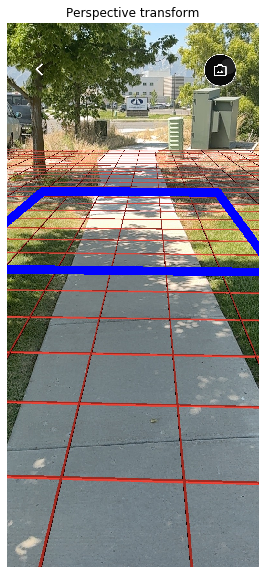

In [50]:
transform_matrix, transform_width, transform_height = get_flat_transform(grid_image, sorted_hor, sorted_vert, debug=DEBUG)

## Distance estimation

**Find the distance between any two points in the image.**

The top-down view allows us to use the Euclidean distance between any two points in the image to estimate the real-world distance. The top-down view is a 2D representation of the 3D world, so the Euclidean distance is the same in both.

In [51]:
def transform_point(point: np.ndarray, M: np.ndarray) -> np.ndarray:
    """Transforms a point using a perspective transform matrix.
    
    Args:
        point: The point to transform. Can be in any shape.
        M: The perspective transform matrix.
    
    Returns:
        The transformed point.
    """
    return cv2.perspectiveTransform(np.array(point, dtype=np.float32).reshape(1, -1, 2), M).reshape(2)

In [52]:
def inverse_transform_point(point: np.ndarray, M: np.ndarray) -> np.ndarray:
    """Inverse transforms a point using a perspective transform matrix.

    Args:
        point: The point to transform. Can be in any shape.
        M: The perspective transform matrix.

    Returns:
        The inverse transformed point.
    """
    M_inv = np.linalg.inv(M)
    return cv2.perspectiveTransform(np.array(point, dtype=np.float32).reshape(1, -1, 2), M_inv).reshape(2)

In [53]:
def transform_image(image: np.ndarray, M: np.ndarray, width: int, height: int, debug: bool = False) -> np.ndarray:
    """Transforms an image using a perspective transform matrix.
    
    Args:
        image: The input image.
        M: The perspective transform matrix.
        width: The width of the transformed image.
        height: The height of the transformed image.
        debug: Whether to visualize results.
    
    Returns:
        The transformed image.
    """
    # Perform the perspective transform
    warped = cv2.warpPerspective(image, M, (width, height))
    if debug:
        show_image(warped, "Top-down image", export=True)
    return warped

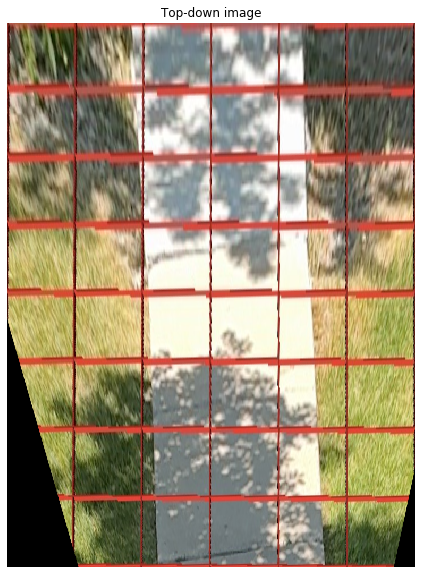

In [54]:
flat_image = transform_image(grid_image, transform_matrix, transform_width, transform_height, debug=DEBUG)

In [64]:
def find_distances(flat_image: np.ndarray, point_pairs: List[List[np.ndarray]], transform_matrix, debug = False) -> None:
    """Finds the distance between pairs of points on the original image.

    Args:
        flat_image: The flat image.
        point_pairs: A list of pairs of points.
        transform_matrix: The perspective transform matrix.
        debug: Whether to visualize results.
    
    Returns:
        A list of distances.
    """
    # Apply the perspective transformation
    transformed_points = cv2.perspectiveTransform(np.array(point_pairs, dtype=np.float32), transform_matrix)
    dists = []
    
    for i in range(len(point_pairs)):
        input_1 = transformed_points[i][0]
        input_2 = transformed_points[i][1]

        # If either point is outside the image, skip
        # if not (0 <= input_1[0] < flat_image.shape[1] and 0 <= input_1[1] < flat_image.shape[0]):
        #     print(f"Segment {input_1} and {input_2} is outside the image, skipping")
        #     dists.append(-1)
        #     continue
        
        # Calculate distance
        calculated_dist = METRIC_GRID_LENGTH * (get_dist(input_1, input_2) / PIXEL_GRID_LENGTH)
        dists.append(calculated_dist)
    
    if debug:
        output = flat_image.copy()
        for i in range(len(point_pairs)):
            input_1 = transformed_points[i][0]
            input_2 = transformed_points[i][1]
#             cv2.circle(output, [round(x) for x in input_1], radius=20, color=(255, 0, 0), thickness=cv2.FILLED)
#             cv2.circle(output, [round(x) for x in input_2], radius=20, color=(255, 0, 0), thickness=cv2.FILLED)
#             cv2.line(output, [round(x) for x in input_1], [round(x) for x in input_2], (255, 0, 0), 10)
            cv2.circle(output, tuple(int(round(x)) for x in input_1), radius=20, color=(255, 0, 0), thickness=cv2.FILLED)
            cv2.circle(output, tuple(int(round(x)) for x in input_2), radius=20, color=(255, 0, 0), thickness=cv2.FILLED)
            cv2.line(output, tuple(int(round(x)) for x in input_1), tuple(int(round(x)) for x in input_2), color=(255, 0, 0), thickness=10)
            draw_text(output, f"{dists[i]:.2f} m", int(round(input_1[0]+input_2[0])//2), int(round(input_1[1]+input_2[1])//2-20), 50, (255, 0, 0), scale=2)
        show_image(output, "Manual Distances")
    
    return dists

In [65]:
def draw_distances(image: np.ndarray, flat_image: np.ndarray, point_pairs: List[List[np.ndarray]], transform_matrix, title = "Distances") -> None:
    """Draws the distances between pairs of points on the original image.

    Args:
        image: The original image.
        flat_image: The flat image.
        point_pairs: A list of pairs of points.
        transform_matrix: The perspective transform matrix.
        title: The title of the window.
    """
    dists = find_distances(flat_image, point_pairs, transform_matrix)
    output = image.copy()
    for i in range(len(point_pairs)):
        input_1 = point_pairs[i][0]
        input_2 = point_pairs[i][1]
#         cv2.circle(output, [round(x) for x in input_1], radius=10, color=(255, 0, 0), thickness=cv2.FILLED)
#         cv2.circle(output, [round(x) for x in input_2], radius=10, color=(255, 0, 0), thickness=cv2.FILLED)
#         cv2.line(output, [round(x) for x in input_1], [round(x) for x in input_2], (255, 0, 0), 5)
        
        cv2.circle(output, tuple(int(round(x)) for x in input_1), radius=10, color=(255, 0, 0), thickness=cv2.FILLED)
        cv2.circle(output, tuple(int(round(x)) for x in input_2), radius=10, color=(255, 0, 0), thickness=cv2.FILLED)
        cv2.line(
            output,
            tuple(int(round(x)) for x in input_1),
            tuple(int(round(x)) for x in input_2),
            color=(255, 0, 0),
            thickness=5
        )
        
        draw_text(output, f"{dists[i]:.2f} m", int(round(input_1[0]+input_2[0])//2), int(round(input_1[1]+input_2[1])//2-5), 50, (255, 0, 0), scale=1)
    show_image(output, title, export=True)

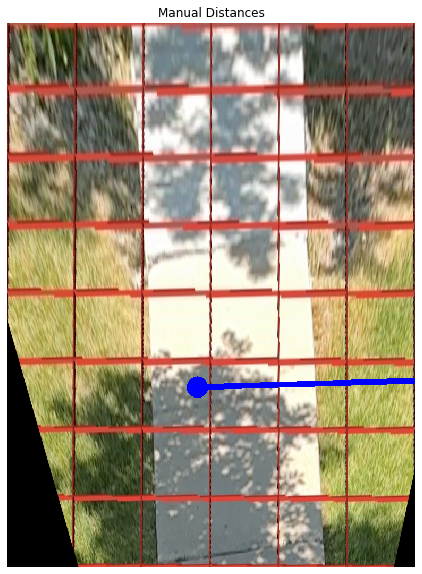

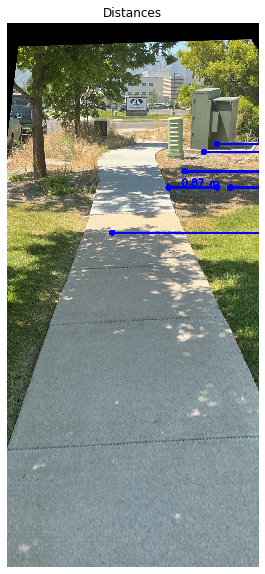

In [66]:
point_pairs = []
point_pairs.append([[325, 650], [1400, 650]])
point_pairs.append([[500, 510], [650, 510]])
point_pairs.append([[690, 510], [1230, 510]])
point_pairs.append([[550, 460], [1170, 460]])
point_pairs.append([[610, 400], [1110, 400]])
point_pairs.append([[650, 375], [1075, 375]])

find_distances(flat_image, point_pairs, transform_matrix, debug=DEBUG)
draw_distances(raw_image, flat_image, point_pairs, transform_matrix)

## Sidewalk width estimation

**Find the width of the sidewalk in the image.**

Using the sidewalk segmentation, combined with distance estimation, we can find the width of the sidewalk at each part of the image. Since people will usually be holding the camera in the direction of the sidewalk, we can assume the sidewalk is roughly centered. So, for now, this can be done by drawing horizontal lines across the sidewalk, and using the distance between these lines to get the sidewalk width, along with any obstacles in it.

In [69]:
def get_sidewalk_point_pairs(image: np.ndarray, segment_mask: np.ndarray, line_spacing = 10,
                             smallest_section = 10, ignore_gaps = False, debug = False) -> List[List[np.ndarray]]:
    """Gets the point pairs for the sidewalk.

    Args:
        image: The input image.
        segment_mask: The sidewalk segmentation mask.
        line_spacing: The spacing between each horizontal line to scan.
        smallest_section: The smallest section of sidewalk to treat as a continuous portion (to avoid noise).
        ignore_gaps: Whether to ignore gaps in the sidewalk (just return the left and rightmost points).
        debug: Whether to visualize results.

    Returns:
        A list of pairs of points.
    """
    # Draw a horizontal line across the sidewalk every X pixels
    lines = []
    for i in range(round(segment_mask.shape[0] * 0.15), round(segment_mask.shape[0] * 0.9), line_spacing):
        # Find the sidewalk points
        sidewalk_points = np.argwhere(segment_mask[i] == 255)
        if len(sidewalk_points) == 0:
            continue
        # If we should ignore gaps, just return the left and rightmost points
        if ignore_gaps:
            lines.append([[sidewalk_points[0][0], i], [sidewalk_points[-1][0], i]])
            continue
        # Draw a line for every continuous portion of the sidewalk
        start = sidewalk_points[0][0]
        for j in range(1, len(sidewalk_points)):
            if sidewalk_points[j][0] - sidewalk_points[j-1][0] > smallest_section:
                # Draw a line from start to j-1
                if sidewalk_points[j-1][0] - start > smallest_section:
                    lines.append([[start, i], [sidewalk_points[j-1][0], i]])
                start = sidewalk_points[j][0]
        # Draw a line from start to the end
        if sidewalk_points[-1][0] - start > smallest_section:
            lines.append([[start, i], [sidewalk_points[-1][0], i]])
    
    # Visualize
    if debug:
        output = image.copy()
        for line in lines:
#             cv2.circle(output, [round(x) for x in line[0]], radius=5, color=(0, 255, 0), thickness=cv2.FILLED)
#             cv2.circle(output, [round(x) for x in line[1]], radius=5, color=(0, 255, 0), thickness=cv2.FILLED)
#             cv2.line(output, [round(x) for x in line[0]], [round(x) for x in line[1]], (0, 255, 0), 2)
            cv2.circle(output, tuple(int(round(x)) for x in line[0]), radius=5, color=(0, 255, 0), thickness=cv2.FILLED)
            cv2.circle(output, tuple(int(round(x)) for x in line[1]), radius=5, color=(0, 255, 0), thickness=cv2.FILLED)
            cv2.line(
                output,
                tuple(int(round(x)) for x in line[0]),
                tuple(int(round(x)) for x in line[1]),
                color=(0, 255, 0),
                thickness=2
            )
        show_image(output, "Sidewalk point pairs")

    return lines

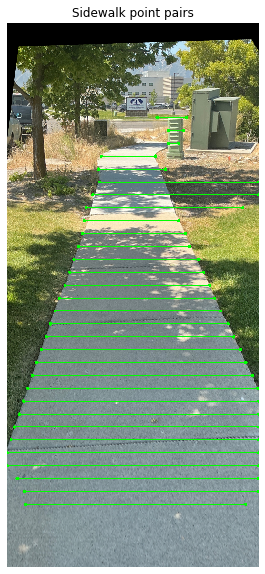

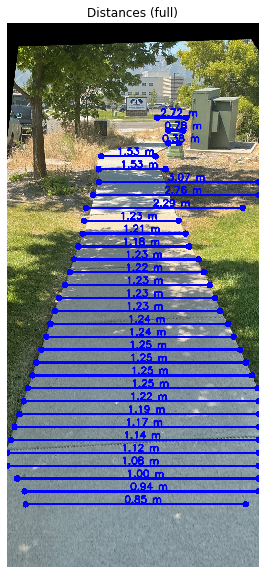

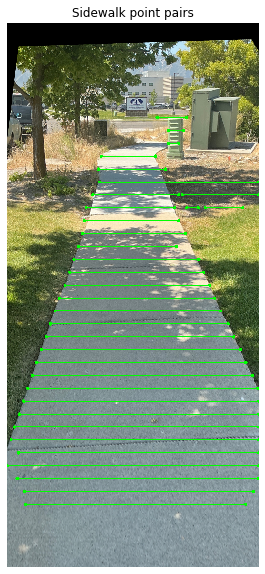

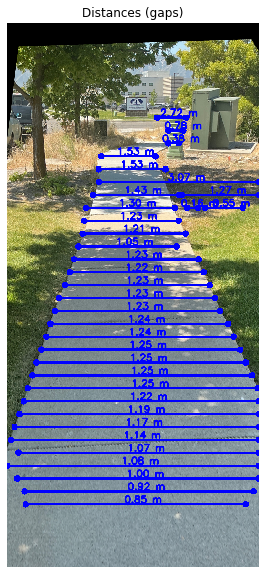

In [70]:
# Get the sidewalk point pairs ignoring gaps
sidewalk_point_pairs = get_sidewalk_point_pairs(raw_image, segment_mask, line_spacing=LINE_SPACING, ignore_gaps=True, debug=DEBUG)
if DEBUG:
    draw_distances(raw_image, flat_image, sidewalk_point_pairs, transform_matrix, title="Distances (full)")
# Get the sidewalk point pairs including gaps
sidewalk_point_pairs = get_sidewalk_point_pairs(raw_image, segment_mask, line_spacing=LINE_SPACING, ignore_gaps=False, debug=DEBUG)
if DEBUG:
    draw_distances(raw_image, flat_image, sidewalk_point_pairs, transform_matrix, title="Distances (gaps)")

In [71]:
def plot_sidewalk_width(sidewalk_point_pairs: List[List[np.ndarray]], transform_matrix) -> None:
    """Plots the sidewalk width for visualization.

    Args:
        sidewalk_point_pairs: A list of pairs of points.
        transform_matrix: The perspective transform matrix.
    """
    dists = find_distances(flat_image, sidewalk_point_pairs, transform_matrix)
    y = [sidewalk_point_pairs[i][0][1] for i in range(len(sidewalk_point_pairs))]
    plt.scatter(y, dists)
    plt.title("Sidewalk width")
    plt.xlabel("Y coordinate (pixels from top)")
    plt.ylabel("Width (m)")
    plt.show()

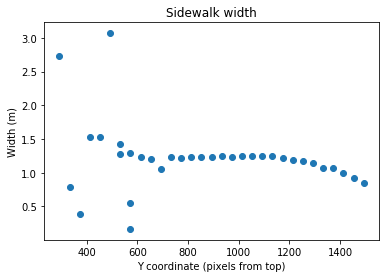

Median sidewalk width: 1.226 m


In [72]:
if DEBUG:
    plot_sidewalk_width(sidewalk_point_pairs, transform_matrix)

# Output the median sidewalk width
dists = find_distances(flat_image, sidewalk_point_pairs, transform_matrix)
sidewalk_width = np.median(dists)
print(f"Median sidewalk width: {sidewalk_width:.3f} m")

## Data Export

Here, we export results to be used for top-down stitching, which needs multiple frames to work. We save the raw image, the grid lines, the top-down view and the transformation matrix to get it, and the sidewalk segmentation.

In [73]:
def export_image(image: np.ndarray, filename: str) -> None:
    """Exports an image to the export folder.

    Args:
        image: The image to export.
        filename: The filename to export to.
    """
    cv2.imwrite(os.path.join(EXPORT_PATH, filename), image)

# Export raw image
export_image(raw_image, "Raw image.jpg")
# Export sidewalk segment mask
export_image(segment_mask, "Sidewalk mask.png")
# Export other data
with open(os.path.join(EXPORT_PATH, "output.json"), "w") as f:
    json.dump({"sidewalk_width": sidewalk_width,
               "transform_matrix": transform_matrix.tolist(),
               "transform_metric_width": transform_width / PIXEL_GRID_LENGTH * METRIC_GRID_LENGTH,
               "transform_metric_height": transform_height / PIXEL_GRID_LENGTH * METRIC_GRID_LENGTH,
               "grid_lines_horizontal": sorted_hor,
               "grid_lines_vertical": sorted_vert},
               f, indent=4)